Checkpoint from model20  
prev model: model_20

In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, RandomHorizontalFlip, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm
from hack_train import predict

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 98 * len(GPUs)
LR = 3e-4
NUM_WORKERS = 24
MODEL_NAME = 'model_24'

In [5]:
CHECKPOINT_MODEL_NAME = 'model_20'

In [6]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [7]:
def train(model, loader, loss_fn, optimizer, device):
    model.train()
    train_loss = []
    for batch in stqdm(loader, total=len(loader), desc="training...", leave=True):
        images = batch["image"].to(device)  # B x 3 x CROP_SIZE x CROP_SIZE
        landmarks = batch["landmarks"]  # B x (2 * NUM_PTS)

        pred_landmarks = model(images).cpu()  # B x (2 * NUM_PTS)
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        train_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.mean(train_loss)

In [8]:
def validate(model, loader, loss_fn, device):
    model.eval()
    val_loss = []
    for batch in stqdm(loader, total=len(loader), desc="validation...", leave=True):
        images = batch["image"].to(device)
        landmarks = batch["landmarks"]

        with torch.no_grad():
            pred_landmarks = model(images).cpu()
        loss = loss_fn(pred_landmarks, landmarks, reduction="mean")
        val_loss.append(loss.item())

    return np.mean(val_loss)

In [9]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    RandomHorizontalFlip(0.1),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ColorJitter(brightness=0.125, contrast=0.125, saturation=0.125, hue=0.125), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
    TransformByKeys(transforms.RandomErasing(p=0.33, scale=(0.02, 0.33), ratio=(0.3, 3.3)), ("image",)),
])

In [10]:
test_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
    TransformByKeys(transforms.Normalize(mean=[0.4782, 0.3758, 0.3277], std=[0.3077, 0.2652, 0.2521]), ("image",)),
])

In [11]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
val_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), test_transforms, split="val")

Total lines (without header): 393930
Loading train dataset (315144 lines)



Total lines (without header): 393930
Loading val dataset (78786 lines)


In [12]:
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                 shuffle=False, drop_last=False)

In [13]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda', index=0)

In [14]:
model = models.resnext101_32x8d(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2 * NUM_PTS, bias=True)

model = nn.DataParallel(model, device_ids=GPUs)
model.to(device)

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [15]:
with open(os.path.join(DATA_DIR, f"{CHECKPOINT_MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [16]:
optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=0.02, amsgrad=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=1)
train_loss_fn = fnn.smooth_l1_loss
val_loss_fn = fnn.mse_loss

In [17]:
N_EPOCHS = 100
best_val_loss = np.inf
for epoch in stqdm(range(N_EPOCHS), total=N_EPOCHS, desc="Epoch"):
    train_loss = train(model, train_dataloader, train_loss_fn, optimizer, device=device)
    val_loss = validate(model, val_dataloader, val_loss_fn, device=device)
    lr_scheduler.step(val_loss)
    print("Epoch #{:2}:\ttrain loss (smooth_l1): {:.5f}\tval loss (mse): {:.5f}".format(epoch, train_loss, val_loss))
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "wb") as fp:
            torch.save(model.state_dict(), fp)

Epoch # 0:	train loss (smooth_l1): 0.38771	val loss (mse): 1.48313


Epoch # 1:	train loss (smooth_l1): 0.38187	val loss (mse): 1.51139


Epoch # 2:	train loss (smooth_l1): 0.37708	val loss (mse): 1.49570


Epoch # 3:	train loss (smooth_l1): 0.34822	val loss (mse): 1.43015


Epoch # 4:	train loss (smooth_l1): 0.33657	val loss (mse): 1.43552


Epoch # 5:	train loss (smooth_l1): 0.33025	val loss (mse): 1.43084


Epoch # 6:	train loss (smooth_l1): 0.31527	val loss (mse): 1.41551


Epoch # 7:	train loss (smooth_l1): 0.30923	val loss (mse): 1.42214


Epoch # 8:	train loss (smooth_l1): 0.30515	val loss (mse): 1.42636


Epoch # 9:	train loss (smooth_l1): 0.29766	val loss (mse): 1.43005


Exception in thread Thread-40197:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.6/dist-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.6/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authkey=process.current_process().authkey)
  File "/usr/lib/py

KeyboardInterrupt: 

In [18]:
f'Best validation loss: {best_val_loss}'

'Best validation loss: 1.415506882231627'

In [19]:
optimizer

AdamW (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 3.75e-05
    weight_decay: 0.02
)

In [20]:
lr_scheduler.state_dict()

{'factor': 0.5,
 'min_lrs': [0],
 'patience': 1,
 'verbose': False,
 'cooldown': 0,
 'cooldown_counter': 0,
 'mode': 'min',
 'threshold': 0.0001,
 'threshold_mode': 'rel',
 'best': 1.415506882231627,
 'num_bad_epochs': 1,
 'mode_worse': inf,
 'eps': 1e-08,
 'last_epoch': 10,
 '_last_lr': [3.75e-05]}

In [21]:
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_best.pth"), "rb") as fp:
    best_state_dict = torch.load(fp, map_location="cpu")
    model.load_state_dict(best_state_dict)

In [22]:
test_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'test'), test_transforms, split="test")
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                  shuffle=False, drop_last=False)

Total lines (without header): 99819


In [23]:
test_predictions = predict(model, test_dataloader, device)
with open(os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl"), "wb") as fp:
    pickle.dump({"image_names": test_dataset.image_names,
                 "landmarks": test_predictions}, fp)

In [24]:
create_submission(DATA_DIR, test_predictions,
                 os.path.join(DATA_DIR, f"{MODEL_NAME}_submit_val_loss_{best_val_loss:.5f}.csv"))

In [25]:
TEST_PREDICTIONS_FILENAME = os.path.join(DATA_DIR, f"{MODEL_NAME}_test_predictions.pkl")
NUM_IMAGES_TO_SHOW = 16
NUM_COLS = 4
NUM_ROWS = NUM_IMAGES_TO_SHOW // NUM_COLS + int(NUM_IMAGES_TO_SHOW % NUM_COLS != 0)

In [26]:
def draw_landmarks(image, landmarks):
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [27]:
with open(TEST_PREDICTIONS_FILENAME, "rb") as fp:
    results = pickle.load(fp)
image_names = results["image_names"]
landmarks = results["landmarks"]

print("Images:", len(image_names))
print("Landmarks shape:", landmarks.shape)

if len(image_names) < NUM_IMAGES_TO_SHOW:
    raise RuntimeError(f"Choose less images to show, you have only {len(image_names)}")

Images: 99819
Landmarks shape: (99819, 971, 2)


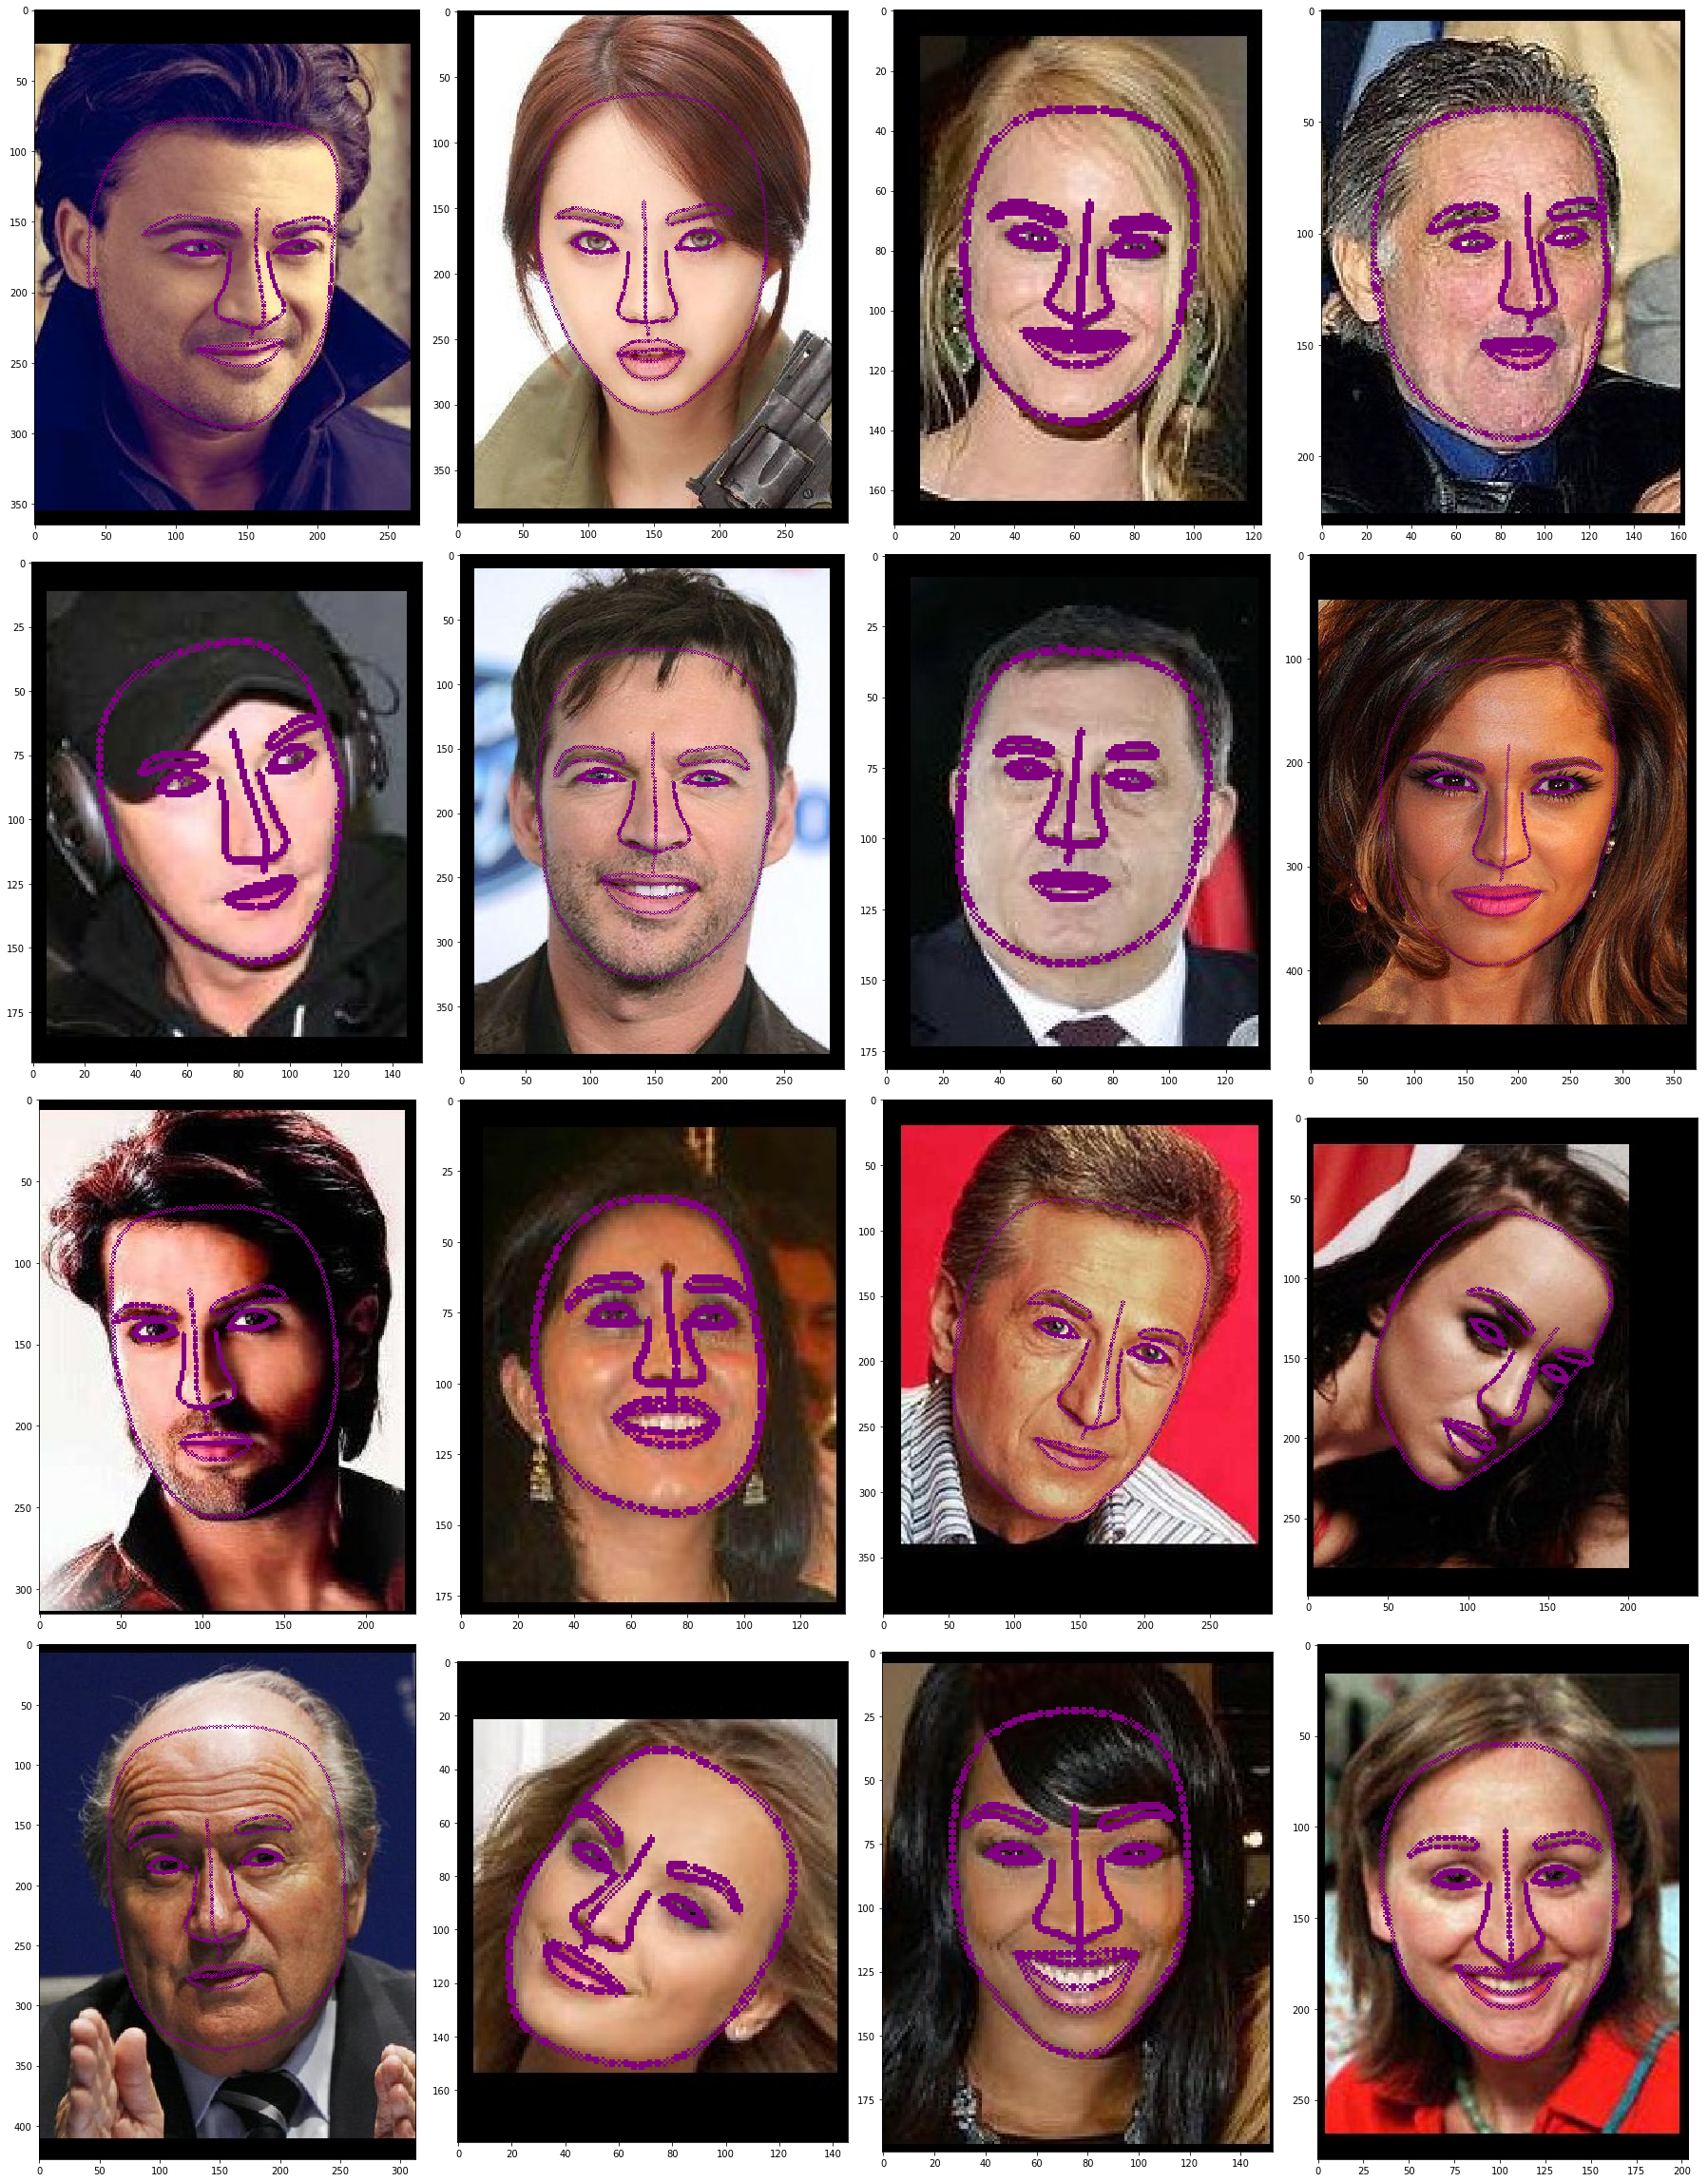

In [28]:
random_idxs = np.random.choice(len(image_names), size=min(NUM_IMAGES_TO_SHOW, len(image_names)), replace=False)

plt.figure(figsize=(25, NUM_ROWS * 8))
for i, idx in enumerate(random_idxs, 1):
    image = cv2.imread(image_names[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = draw_landmarks(image, landmarks[idx])
    
    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image)

plt.tight_layout()
plt.show()